In [1]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
import scipy.stats as scs
from pathlib import Path
import math
import matplotlib.pyplot as plt

# Implement portfolio credit risk simulation model

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [3]:
exposure.shape

(100, 8)

In [4]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

In [5]:
# -------- Insert your code here -------- #
filename_save_out = 'Losses_out'
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios
    # -------- Insert your code here -------- #

    # Generate systemic risk factors (correlated normal variables)
    y_out = np.random.randn(Nout, rho.shape[0]) # Independent standard normal variables
    y_out = np.dot(y_out, sqrt_rho.T) # Correlated standard normal variables

    # Map systemic shocks to counterparties based on their assigned credit drivers
    y_out_mapped = y_out[:, driver.astype(int) - 1]  # Adjust for zero-based index
    
    z_out = np.random.randn(Nout, K)

    sigma_j_out = np.sqrt(1 - beta ** 2)

    # Initialize loss matrix
    losses_out = np.zeros((Nout, K))

    for s in range(1, Nout + 1):
        # -------- Insert your code here -------- #
        # Compute total creditworthiness index (W)
        creditworthiness_index = beta * y_out_mapped[s - 1, :] + sigma_j_out * z_out[s - 1, :]
        # Assign new credit states based on transition boundaries
        credit_states = (creditworthiness_index[:, None] > CS_Bdry).sum(axis=1)

        # Compute out-of-sample losses
        losses_out[s - 1, :] = exposure[np.arange(K), credit_states]
    # Losses_out (sparse matrix)
    Losses_out = scipy.sparse.csr_matrix(losses_out)

In [6]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]

        # Compute z-score for given quantile level
        z_alpha = scs.norm.ppf(alf) 

        portfolio_losses = np.dot(Losses_out.toarray(), x0[portN])
        
        # Sort portfolio losses in increasing order
        sorted_losses = np.sort(portfolio_losses)

        # Compute Mean and Standard Deviation for Normal Approximation (In-Sample)
        mu_p = np.mean(portfolio_losses)
        sigma_p = np.std(portfolio_losses)

        VaRout[portN, q] = sorted_losses[int(math.ceil(Nout * alf)) - 1]
        VaRinN[portN, q] = mu_p + z_alpha * sigma_p
        CVaRout[portN, q] = (1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) * VaRout[portN, q] + sum(sorted_losses[int(math.ceil(Nout * alf)):]))
        CVaRinN[portN, q] = mu_p + (scs.norm.pdf(z_alpha) / (1 - alf)) * sigma_p

In [7]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

In [8]:
for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    # Initialize loss matrix for MC1 (5000 x 100)
    Losses_inMC1 = np.zeros((Nin, K))

    # Generate systemic risk factors (correlated normal variables)
    y_inMC1 = np.random.randn(np.int32(np.ceil(Nin / Ns)), rho.shape[0])  # Independent normal variables
    y_inMC1 = np.dot(y_inMC1, sqrt_rho.T)  # Correlated normal variables

    # Map systemic shocks to counterparties based on their assigned credit drivers
    y_inMC1_mapped = y_inMC1[:, driver.astype(int) - 1]  # Adjust for zero-based index

    # Generate idiosyncratic shocks
    z_inMC1 = np.random.randn(Nin, K)
    
    # Compute counterparty-specific risk scaling factor
    sigma_j_inMC1 = np.sqrt(1 - beta ** 2)

    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            index = (s - 1) * Ns + (si - 1)  # Compute index for idiosyncratic shock in Losses_inMC1
            if index >= Nin:
                break  # Prevent overflow if Nin is not perfectly divisible by Ns

            # Compute total creditworthiness index (W)
            creditworthiness_index = beta * y_inMC1_mapped[s - 1, :] + sigma_j_inMC1 * z_inMC1[index, :]

            # Assign new credit states based on transition boundaries
            credit_states = (creditworthiness_index[:, None] > CS_Bdry).sum(axis=1)

            # Compute in-sample losses
            Losses_inMC1[index, :] = exposure[np.arange(K), credit_states]

    # Monte Carlo approximation 2
    # Initialize loss matrix for MC2 (5000 x 100)
    Losses_inMC2 = np.zeros((Nin, K))

    # Generate systemic risk factors (correlated normal variables)
    y_inMC2 = np.random.randn(Nin, rho.shape[0])  # Independent normal variables
    y_inMC2 = np.dot(y_inMC2, sqrt_rho.T)  # Correlated normal variables

    # Map systemic shocks to counterparties based on their assigned credit drivers
    y_inMC2_mapped = y_inMC2[:, driver.astype(int) - 1]  # Adjust for zero-based index

    # Generate idiosyncratic shocks
    z_inMC2 = np.random.randn(Nin, K)

    # Compute counterparty-specific risk scaling factor
    sigma_j_inMC2 = np.sqrt(1 - beta ** 2)

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # Compute total creditworthiness index (W)
        creditworthiness_index = beta * y_inMC2_mapped[s - 1, :] + sigma_j_inMC2 * z_inMC2[s - 1, :]

        # Assign new credit states based on transition boundaries
        credit_states = (creditworthiness_index[:, None] > CS_Bdry).sum(axis=1)

        # Compute in-sample losses
        Losses_inMC2[s - 1, :] = exposure[np.arange(K), credit_states]

    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = np.dot(Losses_inMC1, x0[portN])
            portf_loss_inMC1 = np.sort(portf_loss_inMC1)

            portf_loss_inMC2 = np.dot(Losses_inMC2, x0[portN])
            portf_loss_inMC2 = np.sort(portf_loss_inMC2)

            # Compute portfolio mean and portfolio standard deviation of losses
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)

            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            mu_p_MC1 =  np.mean(portf_loss_inMC1)
            sigma_p_MC1 =  np.std(portf_loss_inMC1)
            mu_p_MC2 = np.mean(portf_loss_inMC2)
            sigma_p_MC2 = np.std(portf_loss_inMC2)

            # Compute z-score for given quantile level
            z_alpha = scs.norm.ppf(alf)

            # Compute VaR and CVaR for the current trial 
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + z_alpha * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + z_alpha * sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC1[portN, q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC2[portN, q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):]))
            CVaRinN1[portN, q][tr - 1] =  mu_p_MC1 + (scs.norm.pdf(z_alpha) / (1 - alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] =  mu_p_MC2 + (scs.norm.pdf(z_alpha) / (1 - alf)) * sigma_p_MC2

In [9]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37290619.22, CVaR 99.0% = $44771597.87
In-sample MC1: VaR 99.0% = $37152586.05, CVaR 99.0% = $44442608.50
In-sample MC2: VaR 99.0% = $37143720.05, CVaR 99.0% = $44775010.59
In-sample No: VaR 99.0% = $26283824.90, CVaR 99.0% = $29181494.16
In-sample N1: VaR 99.0% = $26213105.80, CVaR 99.0% = $29103916.83
In-sample N2: VaR 99.0% = $26240795.20, CVaR 99.0% = $29134485.38

Out-of-sample: VaR 99.9% = $54452130.32, CVaR 99.9% = $61852229.09
In-sample MC1: VaR 99.9% = $53471390.68, CVaR 99.9% = $60414362.97
In-sample MC2: VaR 99.9% = $54191046.71, CVaR 99.9% = $62316659.50
In-sample No: VaR 99.9% = $32815852.83, CVaR 99.9% = $35183282.53
In-sample N1: VaR 99.9% = $32729673.66, CVaR 99.9% = $35091500.10
In-sample N2: VaR 99.9% = $32763853.35, CVaR 99.9% = $35128032.09


Portfolio 2:

Out-of-sample: VaR 99.0% = $27396396.30, CVaR 99.0% = $33557575.00
In-sample MC1: VaR 99.0% = $27420462.14, CVaR 99.0% = $33232614.51
In-sample MC2: VaR 99.0% = $27423030

# Analyze Results

## Plotting the Distribution

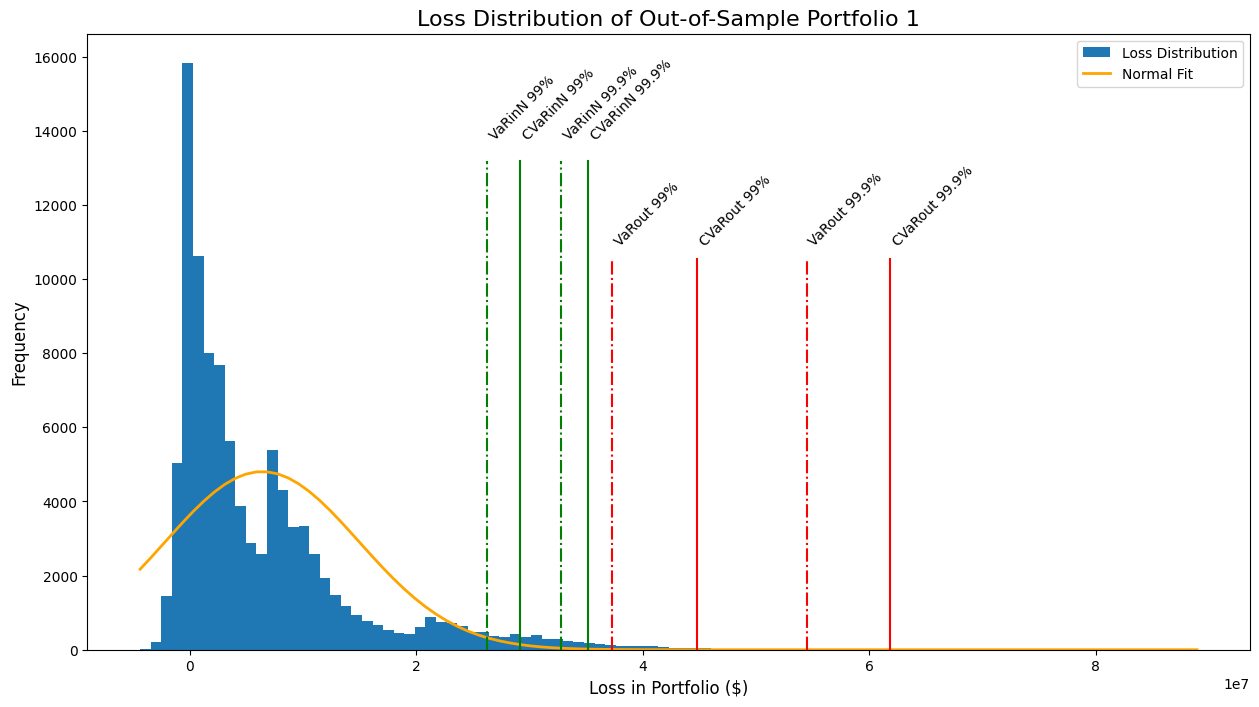

In [10]:
# Plot the distribution of portfolio losses for the out of sample portfolio 1
fig = plt.figure(figsize=(15,8))

# Compute portfolio losses for out-of-sample Portfolio 1
portfolio_losses = np.dot(Losses_out.toarray(), x0[0])

# Retrieve precomputed VaR and CVaR for Portfolio 1
VaRout_99, VaRout_999 = VaRout[0, 0], VaRout[0, 1]  # Out-of-Sample 99% and 99.9%
CVaRout_99, CVaRout_999 = CVaRout[0, 0], CVaRout[0, 1]  # Out-of-Sample 99% and 99.9%

VaRinN_99, VaRinN_999 = VaRinN[0, 0], VaRinN[0, 1]  # In-Sample (Normal) 99% and 99.9%
CVaRinN_99, CVaRinN_999 = CVaRinN[0, 0], CVaRinN[0, 1]  # In-Sample (Normal) 99% and 99.9%

# Plot the histogram of portfolio losses
mu, sigma = np.mean(portfolio_losses), np.std(portfolio_losses)
count, bins, ignored = plt.hist(portfolio_losses, 100, density=False, label="Loss Distribution")
norm = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))
norm = norm * sum(count) / sum(norm)

plt.plot(bins, norm, linewidth=2, color='orange', label="Normal Fit")

# Define values for plotting
VaR_values = [VaRout_99, VaRout_999, VaRinN_99, VaRinN_999]
CVaR_values = [CVaRout_99, CVaRout_999, CVaRinN_99, CVaRinN_999]
labels = ["VaRout 99%", "VaRout 99.9%", "VaRinN 99%", "VaRinN 99.9%",
          "CVaRout 99%", "CVaRout 99.9%", "CVaRinN 99%", "CVaRinN 99.9%"]

# Plot VaR and CVaR values
for i in range(2):  # Out-of-sample (VaRout, CVaRout)
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.5], color='r', linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.45, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.5], color='r', linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.45, labels[i + 4], fontsize=10, rotation=45)

for i in range(2, 4):  # In-sample Normal Approximation (VaRinN, CVaRinN)
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.2], color='g', linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.15, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.2], color='g', linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.15, labels[i + 4], fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Loss in Portfolio ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Loss Distribution of Out-of-Sample Portfolio 1', fontsize=16)
plt.legend()

# Show plot
plt.show()

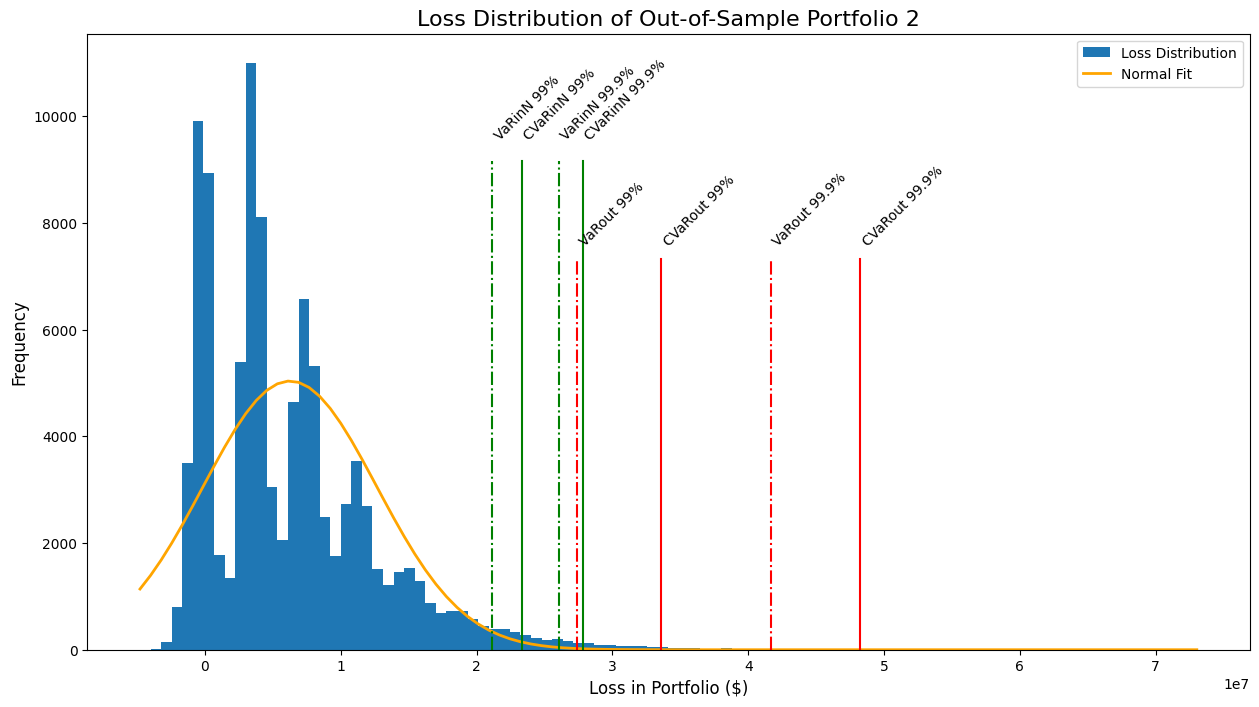

In [11]:
# Plot the distribution of portfolio losses for the out of sample portfolio 2
fig = plt.figure(figsize=(15,8))

# Compute portfolio losses for Out-of-Sample Portfolio 2
portfolio_losses = np.dot(Losses_out.toarray(), x0[1])  # Portfolio 2 weights

# Retrieve precomputed VaR and CVaR for Portfolio 2
VaRout_99, VaRout_999 = VaRout[1, 0], VaRout[1, 1]  # Out-of-Sample 99% and 99.9%
CVaRout_99, CVaRout_999 = CVaRout[1, 0], CVaRout[1, 1]  # Out-of-Sample 99% and 99.9%

VaRinN_99, VaRinN_999 = VaRinN[1, 0], VaRinN[1, 1]  # In-Sample (Normal) 99% and 99.9%
CVaRinN_99, CVaRinN_999 = CVaRinN[1, 0], CVaRinN[1, 1]  # In-Sample (Normal) 99% and 99.9%

# Plot the histogram of portfolio losses
mu, sigma = np.mean(portfolio_losses), np.std(portfolio_losses)
count, bins, ignored = plt.hist(portfolio_losses, 100, density=False, label="Loss Distribution")
norm = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))
norm = norm * sum(count) / sum(norm)

plt.plot(bins, norm, linewidth=2, color='orange', label="Normal Fit")

# Define values for plotting
VaR_values = [VaRout_99, VaRout_999, VaRinN_99, VaRinN_999]
CVaR_values = [CVaRout_99, CVaRout_999, CVaRinN_99, CVaRinN_999]
labels = ["VaRout 99%", "VaRout 99.9%", "VaRinN 99%", "VaRinN 99.9%",
          "CVaRout 99%", "CVaRout 99.9%", "CVaRinN 99%", "CVaRinN 99.9%"]

# Plot VaR and CVaR values
for i in range(2):  # Out-of-sample (VaRout, CVaRout)
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.5], color='r', linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.45, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.5], color='r', linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.45, labels[i + 4], fontsize=10, rotation=45)

for i in range(2, 4):  # In-sample Normal Approximation (VaRinN, CVaRinN)
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.2], color='g', linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.15, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.2], color='g', linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.15, labels[i + 4], fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Loss in Portfolio ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Loss Distribution of Out-of-Sample Portfolio 2', fontsize=16)
plt.legend()

# Show plot
plt.show()

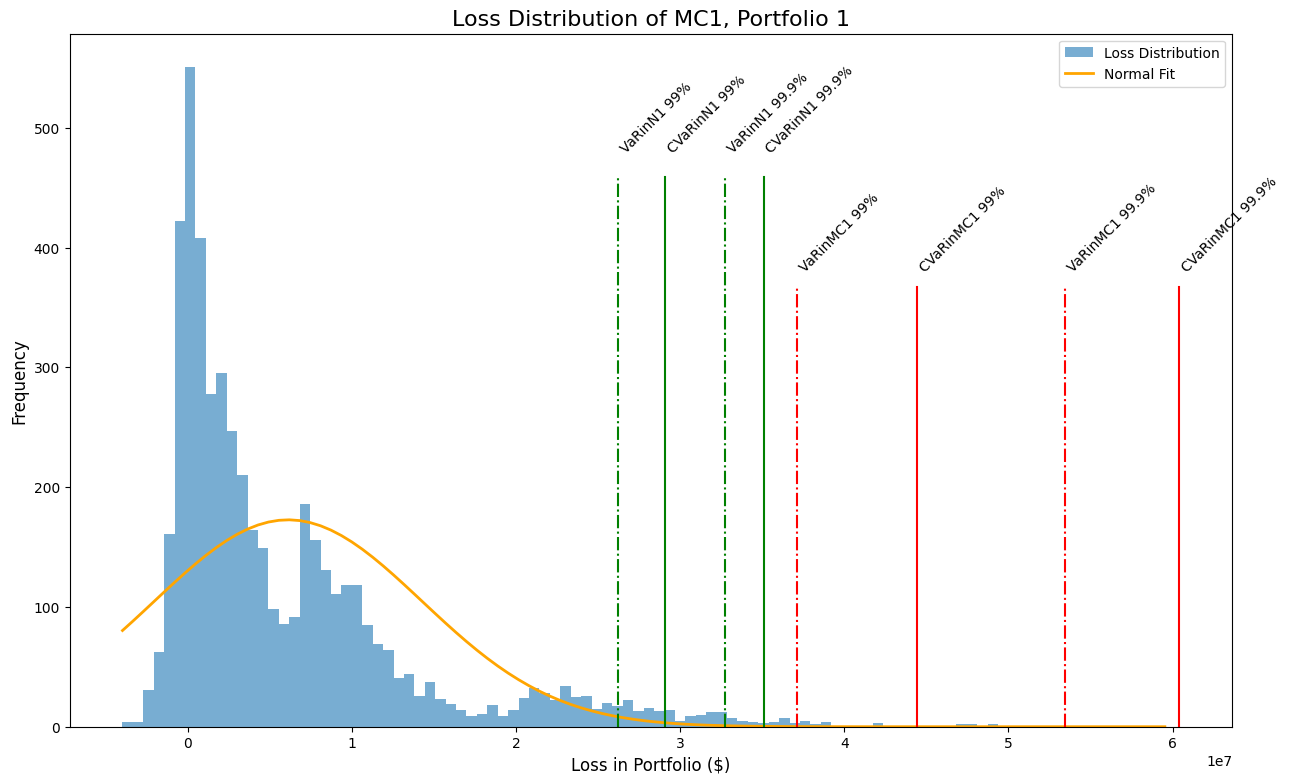

In [12]:
# Plot the distribution of portfolio losses for MC1, Portfolio 1
fig = plt.figure(figsize=(15, 9))

# Compute portfolio losses for MC1, Portfolio 1 (portN = 0)
portfolio_losses = np.dot(Losses_inMC1, x0[0])  # Using Portfolio 1's weights

# Retrieve precomputed VaR and CVaR for MC1 & Normal Approximation (portN = 0)
VaR_MC1_99 = np.mean(VaRinMC1[0, 0])  # Average over trials for smooth plot
VaR_MC1_999 = np.mean(VaRinMC1[0, 1])
CVaR_MC1_99 = np.mean(CVaRinMC1[0, 0])
CVaR_MC1_999 = np.mean(CVaRinMC1[0, 1])

VaR_N1_99 = np.mean(VaRinN1[0, 0])
VaR_N1_999 = np.mean(VaRinN1[0, 1]) 
CVaR_N1_99 = np.mean(CVaRinN1[0, 0])
CVaR_N1_999 = np.mean(CVaRinN1[0, 1])

# Create histogram of portfolio losses

count, bins, ignored = plt.hist(portfolio_losses, bins=100, density=False, alpha=0.6, label="Loss Distribution")

# Fit a normal curve
mu_p, sigma_p = np.mean(portfolio_losses), np.std(portfolio_losses)
norm = scs.norm.pdf(bins, mu_p, sigma_p) * sum(count) / sum(scs.norm.pdf(bins, mu_p, sigma_p))
plt.plot(bins, norm, linewidth=2, color='orange', label="Normal Fit")

# Define values for plotting
VaR_values = [VaR_MC1_99, VaR_MC1_999, VaR_N1_99, VaR_N1_999]
CVaR_values = [CVaR_MC1_99, CVaR_MC1_999, CVaR_N1_99, CVaR_N1_999]
labels = ["VaRinMC1 99%", "VaRinMC1 99.9%", "VaRinN1 99%", "VaRinN1 99.9%",
          "CVaRinMC1 99%", "CVaRinMC1 99.9%", "CVaRinN1 99%", "CVaRinN1 99.9%"]
colors = ["red", "red", "green", "green"]  # MC1 in red, Normal Approx in green

# Plot VaR and CVaR values
for i in range(2):  # VaR and CVaR for both MC1
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.5], color=colors[i], linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.45, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.5], color=colors[i], linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.45, labels[i + 4], fontsize=10, rotation=45)

for i in range(2,4):  # VaR and CVaR for Normal Approximation
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.2], color=colors[i], linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.15, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.2], color=colors[i], linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.15, labels[i + 4], fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Loss in Portfolio ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Loss Distribution of MC1, Portfolio 1', fontsize=16)
plt.legend()

# Show plot
plt.show()

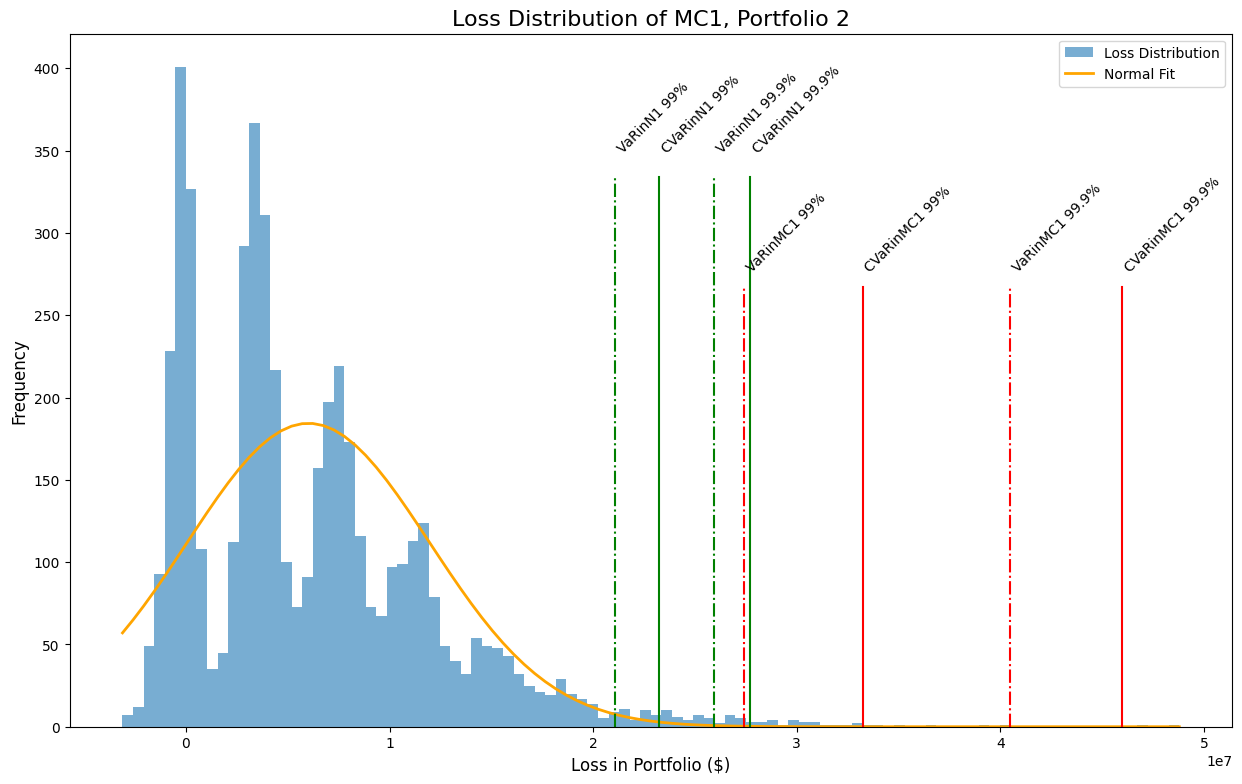

In [13]:
# Plot the distribution of portfolio losses for MC1, Portfolio 2
fig = plt.figure(figsize=(15, 9))

# Compute portfolio losses for MC1, Portfolio 1 (portN = 0)
portfolio_losses = np.dot(Losses_inMC1, x0[1])  # Using Portfolio 1's weights

# Retrieve precomputed VaR and CVaR for MC1 & Normal Approximation (portN = 0)
VaR_MC1_99 = np.mean(VaRinMC1[1, 0])  # Average over trials for smooth plot
VaR_MC1_999 = np.mean(VaRinMC1[1, 1])
CVaR_MC1_99 = np.mean(CVaRinMC1[1, 0])
CVaR_MC1_999 = np.mean(CVaRinMC1[1, 1])

VaR_N1_99 = np.mean(VaRinN1[1, 0])
VaR_N1_999 = np.mean(VaRinN1[1, 1]) 
CVaR_N1_99 = np.mean(CVaRinN1[1, 0])
CVaR_N1_999 = np.mean(CVaRinN1[1, 1])

# Create histogram of portfolio losses

count, bins, ignored = plt.hist(portfolio_losses, bins=100, density=False, alpha=0.6, label="Loss Distribution")

# Fit a normal curve
mu_p, sigma_p = np.mean(portfolio_losses), np.std(portfolio_losses)
norm = scs.norm.pdf(bins, mu_p, sigma_p) * sum(count) / sum(scs.norm.pdf(bins, mu_p, sigma_p))
plt.plot(bins, norm, linewidth=2, color='orange', label="Normal Fit")

# Define values for plotting
VaR_values = [VaR_MC1_99, VaR_MC1_999, VaR_N1_99, VaR_N1_999]
CVaR_values = [CVaR_MC1_99, CVaR_MC1_999, CVaR_N1_99, CVaR_N1_999]
labels = ["VaRinMC1 99%", "VaRinMC1 99.9%", "VaRinN1 99%", "VaRinN1 99.9%",
          "CVaRinMC1 99%", "CVaRinMC1 99.9%", "CVaRinN1 99%", "CVaRinN1 99.9%"]
colors = ["red", "red", "green", "green"]  # MC1 in red, Normal Approx in green

# Plot VaR and CVaR values
for i in range(2):  # VaR and CVaR for both MC1
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.5], color=colors[i], linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.45, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.5], color=colors[i], linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.45, labels[i + 4], fontsize=10, rotation=45)

for i in range(2,4):  # VaR and CVaR for Normal Approximation
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.2], color=colors[i], linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.15, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.2], color=colors[i], linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.15, labels[i + 4], fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Loss in Portfolio ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Loss Distribution of MC1, Portfolio 2', fontsize=16)
plt.legend()

# Show plot
plt.show()

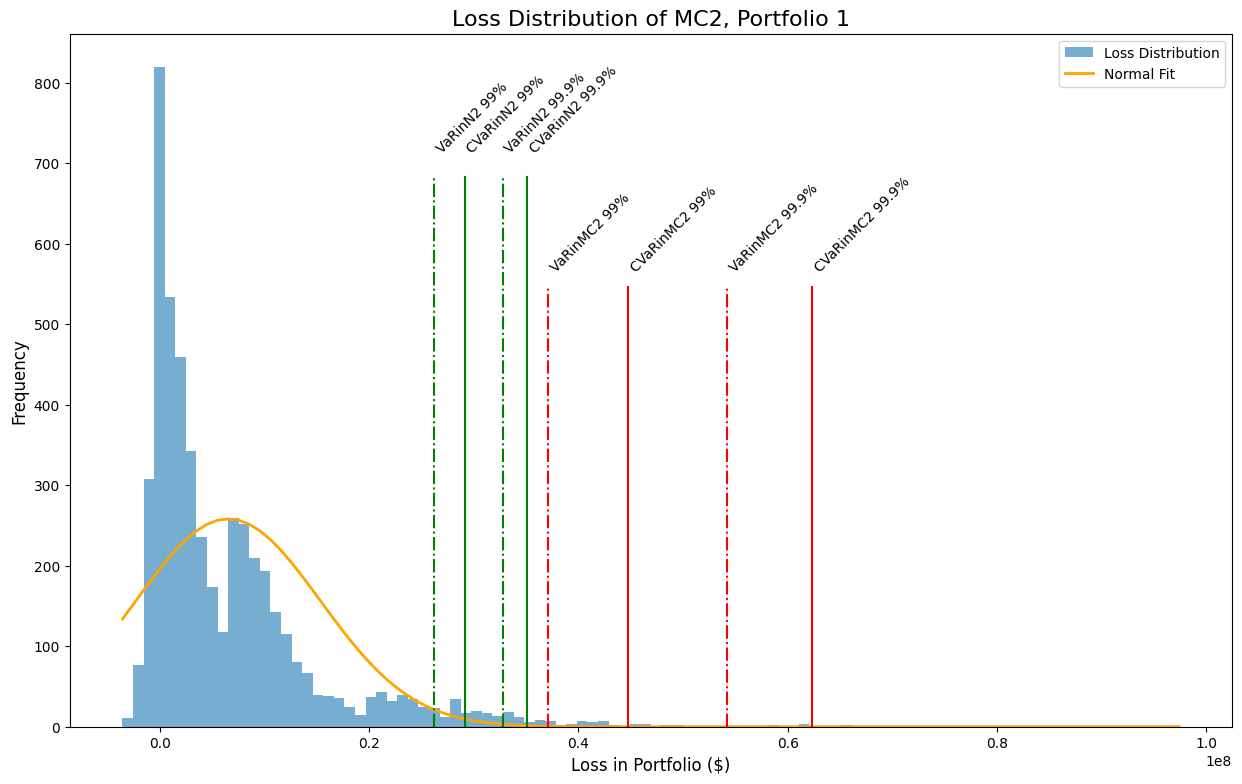

In [19]:
# Plot the distribution of portfolio losses for MC2, Portfolio 1
fig = plt.figure(figsize=(15, 9))

# Compute portfolio losses for MC2, Portfolio 1 (portN = 0)
portfolio_losses = np.dot(Losses_inMC2, x0[0])  # Using Portfolio 1's weights

# Retrieve precomputed VaR and CVaR for MC2 & Normal Approximation (portN = 0)
VaR_MC2_99 = np.mean(VaRinMC2[0, 0])  # Average over trials for smooth plot
VaR_MC2_999 = np.mean(VaRinMC2[0, 1])
CVaR_MC2_99 = np.mean(CVaRinMC2[0, 0])
CVaR_MC2_999 = np.mean(CVaRinMC2[0, 1])

VaR_N2_99 = np.mean(VaRinN2[0, 0])
VaR_N2_999 = np.mean(VaRinN2[0, 1]) 
CVaR_N2_99 = np.mean(CVaRinN2[0, 0])
CVaR_N2_999 = np.mean(CVaRinN2[0, 1])

# Create histogram of portfolio losses
count, bins, ignored = plt.hist(portfolio_losses, bins=100, density=False, alpha=0.6, label="Loss Distribution")

# Fit a normal curve
mu_p, sigma_p = np.mean(portfolio_losses), np.std(portfolio_losses)
norm = scs.norm.pdf(bins, mu_p, sigma_p) * sum(count) / sum(scs.norm.pdf(bins, mu_p, sigma_p))
plt.plot(bins, norm, linewidth=2, color='orange', label="Normal Fit")

# Define values for plotting
VaR_values = [VaR_MC2_99, VaR_MC2_999, VaR_N2_99, VaR_N2_999]
CVaR_values = [CVaR_MC2_99, CVaR_MC2_999, CVaR_N2_99, CVaR_N2_999]
labels = ["VaRinMC2 99%", "VaRinMC2 99.9%", "VaRinN2 99%", "VaRinN2 99.9%",
          "CVaRinMC2 99%", "CVaRinMC2 99.9%", "CVaRinN2 99%", "CVaRinN2 99.9%"]
colors = ["red", "red", "green", "green"]  # MC2 in red, Normal Approx in green

# Plot VaR and CVaR values
for i in range(2):  # VaR and CVaR for both MC2
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.5], color=colors[i], linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.45, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.5], color=colors[i], linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.45, labels[i + 4], fontsize=10, rotation=45)

for i in range(2,4):  # VaR and CVaR for Normal Approximation
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.2], color=colors[i], linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.15, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.2], color=colors[i], linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.15, labels[i + 4], fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Loss in Portfolio ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Loss Distribution of MC2, Portfolio 1', fontsize=16)
plt.legend()

# Show plot
plt.show()


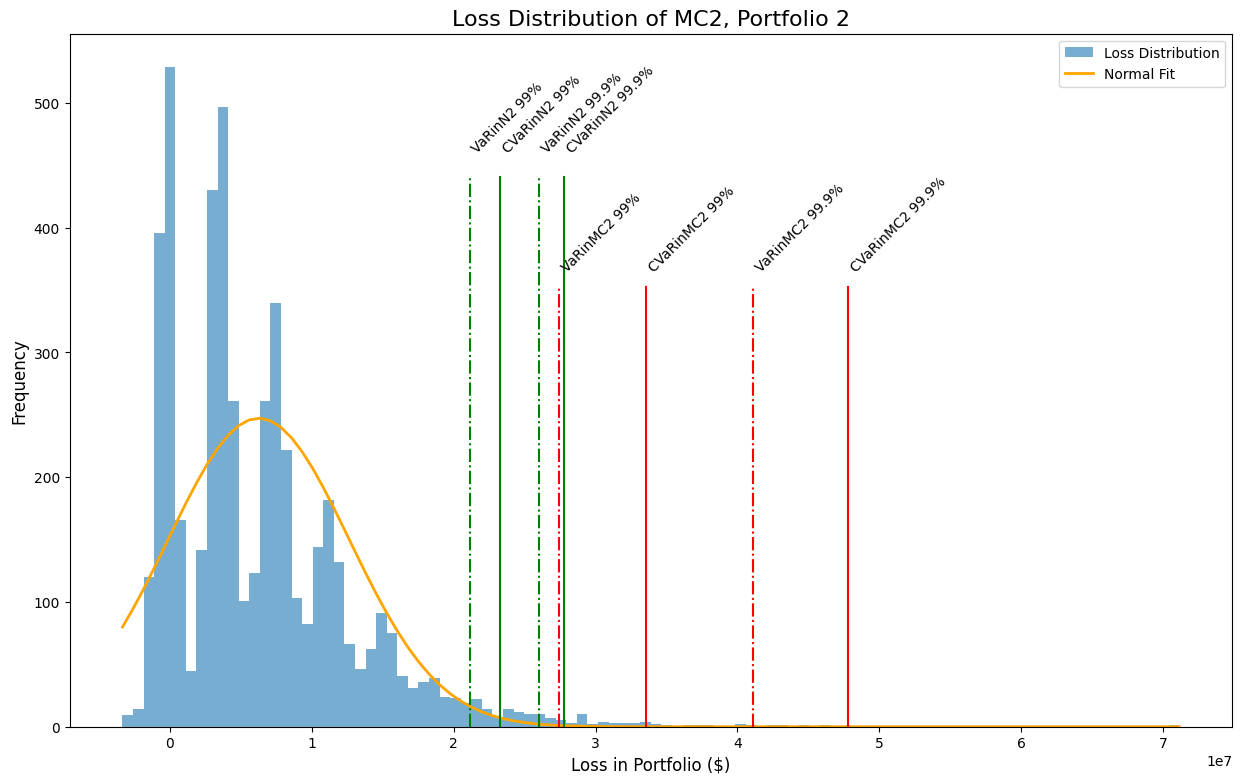

In [15]:
# Plot the distribution of portfolio losses for MC2, Portfolio 2
fig = plt.figure(figsize=(15, 9))

# Compute portfolio losses for MC2, Portfolio 1 (portN = 0)
portfolio_losses = np.dot(Losses_inMC2, x0[1])  # Using Portfolio 1's weights

# Retrieve precomputed VaR and CVaR for MC2 & Normal Approximation (portN = 0)
VaR_MC2_99 = np.mean(VaRinMC2[1, 0])  # Average over trials for smooth plot
VaR_MC2_999 = np.mean(VaRinMC2[1, 1])
CVaR_MC2_99 = np.mean(CVaRinMC2[1, 0])
CVaR_MC2_999 = np.mean(CVaRinMC2[1, 1])

VaR_N2_99 = np.mean(VaRinN2[1, 0])
VaR_N2_999 = np.mean(VaRinN2[1, 1]) 
CVaR_N2_99 = np.mean(CVaRinN2[1, 0])
CVaR_N2_999 = np.mean(CVaRinN2[1, 1])

# Create histogram of portfolio losses
count, bins, ignored = plt.hist(portfolio_losses, bins=100, density=False, alpha=0.6, label="Loss Distribution")

# Fit a normal curve
mu_p, sigma_p = np.mean(portfolio_losses), np.std(portfolio_losses)
norm = scs.norm.pdf(bins, mu_p, sigma_p) * sum(count) / sum(scs.norm.pdf(bins, mu_p, sigma_p))
plt.plot(bins, norm, linewidth=2, color='orange', label="Normal Fit")

# Define values for plotting
VaR_values = [VaR_MC2_99, VaR_MC2_999, VaR_N2_99, VaR_N2_999]
CVaR_values = [CVaR_MC2_99, CVaR_MC2_999, CVaR_N2_99, CVaR_N2_999]
labels = ["VaRinMC2 99%", "VaRinMC2 99.9%", "VaRinN2 99%", "VaRinN2 99.9%",
          "CVaRinMC2 99%", "CVaRinMC2 99.9%", "CVaRinN2 99%", "CVaRinN2 99.9%"]
colors = ["red", "red", "green", "green"]  # MC2 in red, Normal Approx in green

# Plot VaR and CVaR values
for i in range(2):  # VaR and CVaR for both MC2
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.5], color=colors[i], linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.45, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.5], color=colors[i], linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.45, labels[i + 4], fontsize=10, rotation=45)

for i in range(2,4):  # VaR and CVaR for Normal Approximation
    plt.plot([VaR_values[i], VaR_values[i]], [0, max(count)/1.2], color=colors[i], linewidth=1.5, linestyle='-.')
    plt.text(VaR_values[i], max(count) / 1.15, labels[i], fontsize=10, rotation=45)

    plt.plot([CVaR_values[i], CVaR_values[i]], [0, max(count)/1.2], color=colors[i], linewidth=1.5, linestyle='-')
    plt.text(CVaR_values[i], max(count) / 1.15, labels[i + 4], fontsize=10, rotation=45)

# Labels and title
plt.xlabel('Loss in Portfolio ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Loss Distribution of MC2, Portfolio 2', fontsize=16)
plt.legend()

# Show plot
plt.show()


## Sampling Error and Model Error

### Sampling Error

In [16]:
# Initialize dictionary to store sampling errors
sampling_errors_dict = {
    "Metric": [],
    "Sampling Error (% difference)": []
}

# Compute sampling errors for each portfolio and confidence level
for portN in range(2):  # Portfolio 1 and Portfolio 2
    for q in range(alphas.size):  # 99% and 99.9%
        alf = alphas[q]

        # Extract VaR and CVaR values for out-of-sample (true loss distribution)
        VaR_out = VaRout[portN, q]
        CVaR_out = CVaRout[portN, q]

        # Monte Carlo Approximations (MC1 & MC2)
        VaR_MC1 = np.mean(VaRinMC1[portN, q])  # Average over trials
        VaR_MC2 = np.mean(VaRinMC2[portN, q])
        CVaR_MC1 = np.mean(CVaRinMC1[portN, q])
        CVaR_MC2 = np.mean(CVaRinMC2[portN, q])

        # Store Sampling Errors (MC1 & MC2 vs Out-of-Sample) in dictionary
        sampling_errors_dict["Metric"].append(f"{int(alf*100)}% VaR, MC1, Portfolio {portN+1}")
        sampling_errors_dict["Sampling Error (% difference)"].append(f"{100 * (VaR_MC1 - VaR_out) / VaR_out:.2f}%")

        sampling_errors_dict["Metric"].append(f"{int(alf*100)}% CVaR, MC1, Portfolio {portN+1}")
        sampling_errors_dict["Sampling Error (% difference)"].append(f"{100 * (CVaR_MC1 - CVaR_out) / CVaR_out:.2f}%")

        sampling_errors_dict["Metric"].append(f"{int(alf*100)}% VaR, MC2, Portfolio {portN+1}")
        sampling_errors_dict["Sampling Error (% difference)"].append(f"{100 * (VaR_MC2 - VaR_out) / VaR_out:.2f}%")

        sampling_errors_dict["Metric"].append(f"{int(alf*100)}% CVaR, MC2, Portfolio {portN+1}")
        sampling_errors_dict["Sampling Error (% difference)"].append(f"{100 * (CVaR_MC2 - CVaR_out) / CVaR_out:.2f}%")

# Convert dictionary to DataFrame
sampling_error_df = pd.DataFrame(sampling_errors_dict["Sampling Error (% difference)"],
                                 index=sampling_errors_dict["Metric"],
                                 columns=["Sampling Error (% difference)"])
sampling_error_df


,Sampling Error (% difference)
"99% VaR, MC1, Portfolio 1",-0.37%
"99% CVaR, MC1, Portfolio 1",-0.73%
"99% VaR, MC2, Portfolio 1",-0.39%
"99% CVaR, MC2, Portfolio 1",0.01%
"99% VaR, MC1, Portfolio 1",-1.80%
"99% CVaR, MC1, Portfolio 1",-2.32%
"99% VaR, MC2, Portfolio 1",-0.48%
"99% CVaR, MC2, Portfolio 1",0.75%
"99% VaR, MC1, Portfolio 2",0.09%
"99% CVaR, MC1, Portfolio 2",-0.97%


### Model Error

In [17]:
# Initialize dictionary to store model errors
model_errors_dict = {
    "Metric": [],
    "Model Error (% difference)": []
}

# Compute model errors for each portfolio and confidence level
for portN in range(2):  # Portfolio 1 and Portfolio 2
    for q in range(alphas.size):  # 99% and 99.9%
        alf = alphas[q]

        # Extract VaR and CVaR values for out-of-sample (true loss distribution)
        VaR_out = VaRout[portN, q]
        CVaR_out = CVaRout[portN, q]

        # Normal Approximation (N1 & N2)
        VaR_N1 = np.mean(VaRinN1[portN, q])
        VaR_N2 = np.mean(VaRinN2[portN, q])
        CVaR_N1 = np.mean(CVaRinN1[portN, q])
        CVaR_N2 = np.mean(CVaRinN2[portN, q])

        # Store Model Errors (Normal Approx vs Out-of-Sample) in dictionary
        model_errors_dict["Metric"].append(f"{int(alf*100)}% VaR, N1, Portfolio {portN+1}")
        model_errors_dict["Model Error (% difference)"].append(f"{100 * (VaR_N1 - VaR_out) / VaR_out:.2f}%")

        model_errors_dict["Metric"].append(f"{int(alf*100)}% CVaR, N1, Portfolio {portN+1}")
        model_errors_dict["Model Error (% difference)"].append(f"{100 * (CVaR_N1 - CVaR_out) / CVaR_out:.2f}%")

        model_errors_dict["Metric"].append(f"{int(alf*100)}% VaR, N2, Portfolio {portN+1}")
        model_errors_dict["Model Error (% difference)"].append(f"{100 * (VaR_N2 - VaR_out) / VaR_out:.2f}%")

        model_errors_dict["Metric"].append(f"{int(alf*100)}% CVaR, N2, Portfolio {portN+1}")
        model_errors_dict["Model Error (% difference)"].append(f"{100 * (CVaR_N2 - CVaR_out) / CVaR_out:.2f}%")

# Convert dictionary to DataFrame
model_error_df = pd.DataFrame(model_errors_dict["Model Error (% difference)"],
                              index=model_errors_dict["Metric"],
                              columns=["Model Error (% difference)"])
model_error_df

,Model Error (% difference)
"99% VaR, N1, Portfolio 1",-29.71%
"99% CVaR, N1, Portfolio 1",-34.99%
"99% VaR, N2, Portfolio 1",-29.63%
"99% CVaR, N2, Portfolio 1",-34.93%
"99% VaR, N1, Portfolio 1",-39.89%
"99% CVaR, N1, Portfolio 1",-43.27%
"99% VaR, N2, Portfolio 1",-39.83%
"99% CVaR, N2, Portfolio 1",-43.21%
"99% VaR, N1, Portfolio 2",-23.07%
"99% CVaR, N1, Portfolio 2",-30.75%
